In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

import larq as lq
import larq_compute_engine as lce

import matplotlib.pyplot as plt

from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

import random
tf.random.set_seed(3407)
np.random.seed(3407)
random.seed(3407)

from create_spectrogram import (
    create_spectrograms_from_audio_dataset, 
)
from helper_functions import (
    evaluate_prediction,
    get_file_size, 
    convert_bytes, 
    convert_prefetchdataset_to_numpy_arrays,
    predict_and_print_full_results,
    evaluate_time_of_prediction,
    full_int_model_predict,
    get_f1_scores_of_non_overlapping_partitions_full_int_q,
    get_f1_scores_of_bootstarping_partitions_full_int_q,
    )

2024-07-28 21:29:34.722858: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-28 21:29:34.771460: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 21:29:34.771487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 21:29:34.772559: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-28 21:29:34.779394: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-28 21:29:34.780116: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [4]:
train_dataset = tf.keras.utils.audio_dataset_from_directory("../dataset/training", labels='inferred', sampling_rate=16000, batch_size=32, shuffle=True, seed=3407)
test_dataset = tf.keras.utils.audio_dataset_from_directory("../dataset/testing", labels='inferred', sampling_rate=16000, batch_size=32, shuffle=True, seed=3407)
val_dataset = tf.keras.utils.audio_dataset_from_directory("../dataset/validation", labels='inferred', sampling_rate=16000, batch_size=32, shuffle=True, seed=3407)

label_names = np.array(train_dataset.class_names)
print("Classes: ", label_names)

Found 11292 files belonging to 2 classes.


2024-07-28 21:29:37.903649: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-28 21:29:37.904065: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-07-28 21:29:37.972875: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
2024-07-28 21:29:37.976914: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available


Found 1393 files belonging to 2 classes.
Found 1380 files belonging to 2 classes.
Classes:  ['non_target' 'target']


In [5]:
train_spectrogram_ds = create_spectrograms_from_audio_dataset(train_dataset, sample_rate = 16000).cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = create_spectrograms_from_audio_dataset(test_dataset, sample_rate = 16000).cache().prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = create_spectrograms_from_audio_dataset(val_dataset, sample_rate = 16000).cache().prefetch(tf.data.AUTOTUNE)

x_train_np, y_train_np = convert_prefetchdataset_to_numpy_arrays(train_spectrogram_ds)
x_val_np, y_val_np = convert_prefetchdataset_to_numpy_arrays(val_spectrogram_ds)
x_test_np, y_test_np = convert_prefetchdataset_to_numpy_arrays(test_spectrogram_ds)

tf.Tensor([0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0], shape=(32,), dtype=int32)
0
tf.Tensor([0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0], shape=(32,), dtype=int32)
0
tf.Tensor([1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0], shape=(32,), dtype=int32)
1


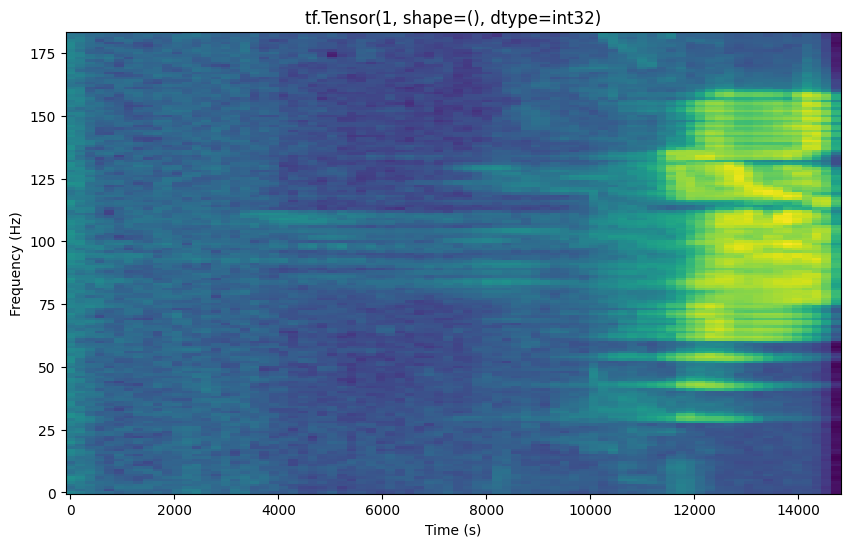

In [6]:
# non-target = 0, target = 1
# Print spectrograms of target or non-target class from dataset
class_number = 1

for i in train_spectrogram_ds:
    print(i[1])
    print(i[1][0].numpy())
    if i[1][0].numpy() == class_number:
        spectrogram = i[0][0]
        height = spectrogram.shape[0]
        width = spectrogram.shape[1]
        X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
        Y = range(height)
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(X, Y, spectrogram)
        plt.title(i[1][0])
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.show()
        break

### HPO

In [16]:

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes, num_of_layers):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_of_conv_layers = num_of_layers

    def build(self, hp):
        model = tf.keras.Sequential()
        
        # Hyperparameters
        kernel_size = hp.Choice('kernel_size', values=[2, 3, 5])
        dense_units = hp.Int('1st_dense_units', min_value=4, max_value=32, step=4)
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        dense_activation = hp.Choice('2nd_dense_activation', values=['softmax', 'sigmoid'])

        # Model architecture
        # Tune number of layers
        for i in range(self.num_of_conv_layers):
            if i == 0:
                model.add(lq.layers.QuantConv2D(
                    filters=hp.Int(f'filters_{i}', min_value=2, max_value=8, step=2), 
                    kernel_size=(kernel_size, kernel_size),
                    input_shape=self.input_shape,
                    kernel_quantizer="ste_sign",
                    kernel_constraint="weight_clip",
                    use_bias=False
                ))
            else:
                model.add(lq.layers.QuantConv2D(
                    filters=hp.Int(f'filters_{i}', min_value=2, max_value=8, step=2), 
                    kernel_size=(kernel_size, kernel_size),
                    input_quantizer="ste_sign",
                    kernel_quantizer="ste_sign",
                    kernel_constraint="weight_clip",
                    use_bias=False
                ))
            model.add(tf.keras.layers.MaxPooling2D((2, 2)))
            model.add(tf.keras.layers.BatchNormalization(scale=False))

        model.add(tf.keras.layers.Flatten())

        model.add(lq.layers.QuantDense(
            units=dense_units,
            kernel_quantizer="ste_sign",
            input_quantizer="ste_sign",
            kernel_constraint="weight_clip",
            use_bias=False
        ))
        model.add(tf.keras.layers.BatchNormalization(scale=False))

        model.add(lq.layers.QuantDense(
            units=self.num_classes,
            kernel_quantizer="ste_sign",
            input_quantizer="ste_sign",
            kernel_constraint="weight_clip",
            use_bias=False
        ))
        model.add(tf.keras.layers.BatchNormalization(scale=False))
        model.add(tf.keras.layers.Activation(dense_activation))
       
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        return model


#### Tune 1 conv2d layer CNN

In [18]:
input_shape = (184, 80, 1)
num_classes = 2

num_of_conv_layers = 1
tuner_1_layer_cnn = RandomSearch(
    CNNHyperModel(input_shape, num_classes, num_of_conv_layers),
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='../hpo_tuner/bnn',
    project_name='bnn_mel_spec_1_conv2d_tuning'
)
tuner_1_layer_cnn.search(train_spectrogram_ds, epochs=5, validation_data=val_spectrogram_ds)
tuner_1_layer_cnn.results_summary()

Trial 20 Complete [00h 01m 50s]
val_accuracy: 0.9315217435359955

Best val_accuracy So Far: 0.9554347693920135
Total elapsed time: 00h 37m 35s
Results summary
Results in ../hpo_tuner/bnn/bnn_1_conv2d_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
kernel_size: 5
1st_dense_units: 28
learning_rate: 0.001585943564699532
2nd_dense_activation: softmax
filters_0: 8
Score: 0.9554347693920135

Trial 11 summary
Hyperparameters:
kernel_size: 5
1st_dense_units: 32
learning_rate: 0.0023095567943677625
2nd_dense_activation: sigmoid
filters_0: 6
Score: 0.9554347693920135

Trial 13 summary
Hyperparameters:
kernel_size: 2
1st_dense_units: 4
learning_rate: 0.00618012909224231
2nd_dense_activation: sigmoid
filters_0: 4
Score: 0.9514492750167847

Trial 12 summary
Hyperparameters:
kernel_size: 5
1st_dense_units: 28
learning_rate: 0.0010705522855084585
2nd_dense_activation: sigmoid
filters_0: 8
Score: 0.949999988079071

Trial 15 summary
Hyper

#### Tune 2 conv2d layers CNN

In [36]:
num_of_layers = 2
tuner_2_layer_cnn = RandomSearch(
    CNNHyperModel(input_shape, num_classes, num_of_layers),
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='../hpo_tuner/bnn',
    project_name='bnn_mel_spec_2_conv2d_tuning'
)
tuner_2_layer_cnn.search(train_spectrogram_ds, epochs=5, validation_data=val_spectrogram_ds)
tuner_2_layer_cnn.results_summary()

Trial 20 Complete [00h 02m 25s]
val_accuracy: 0.8949275612831116

Best val_accuracy So Far: 0.9398550689220428
Total elapsed time: 00h 53m 06s
Results summary
Results in ../hpo_tuner/bnn/bnn_2_conv2d_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 03 summary
Hyperparameters:
kernel_size: 5
1st_dense_units: 28
learning_rate: 0.0063881645876014866
2nd_dense_activation: softmax
filters_0: 4
filters_1: 4
Score: 0.9398550689220428

Trial 15 summary
Hyperparameters:
kernel_size: 5
1st_dense_units: 8
learning_rate: 0.007515970819203388
2nd_dense_activation: sigmoid
filters_0: 8
filters_1: 4
Score: 0.9376811683177948

Trial 05 summary
Hyperparameters:
kernel_size: 2
1st_dense_units: 32
learning_rate: 0.0037652861684021495
2nd_dense_activation: sigmoid
filters_0: 2
filters_1: 8
Score: 0.9329710006713867

Trial 12 summary
Hyperparameters:
kernel_size: 5
1st_dense_units: 28
learning_rate: 0.0013810908036985007
2nd_dense_activation: sigmoid
filters_0: 2
filters

#### Tune 3 conv2d layers CNN

In [46]:
num_of_layers = 3
tuner_3_layer_cnn = RandomSearch(
    CNNHyperModel(input_shape, num_classes, num_of_layers),
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='../hpo_tuner/bnn',
    project_name='bnn_mel_spec_3_conv2d_tuning'
)
tuner_3_layer_cnn.search(train_spectrogram_ds, epochs=5, validation_data=val_spectrogram_ds)
tuner_3_layer_cnn.results_summary()

Trial 20 Complete [00h 02m 29s]
val_accuracy: 0.9268116056919098

Best val_accuracy So Far: 0.9485507309436798
Total elapsed time: 00h 54m 30s
Results summary
Results in ../hpo_tuner/bnn/bnn_3_conv2d_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 09 summary
Hyperparameters:
kernel_size: 2
1st_dense_units: 24
learning_rate: 0.0019990629503147854
2nd_dense_activation: sigmoid
filters_0: 6
filters_1: 4
filters_2: 8
Score: 0.9485507309436798

Trial 03 summary
Hyperparameters:
kernel_size: 5
1st_dense_units: 24
learning_rate: 0.0030956184222862408
2nd_dense_activation: softmax
filters_0: 2
filters_1: 6
filters_2: 4
Score: 0.9286231994628906

Trial 14 summary
Hyperparameters:
kernel_size: 5
1st_dense_units: 32
learning_rate: 0.003499257561375248
2nd_dense_activation: softmax
filters_0: 8
filters_1: 2
filters_2: 4
Score: 0.9286231696605682

Trial 19 summary
Hyperparameters:
kernel_size: 2
1st_dense_units: 28
learning_rate: 0.0007860854030984577
2nd_dense_

In [167]:
tuner_1_layer_cnn.search_space_summary()


Search space summary
Default search space size: 6
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 5], 'ordered': True}
1st_dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 32, 'step': 4, 'sampling': 'linear'}
2nd_dense_activation (Choice)
{'default': 'softmax', 'conditions': [], 'values': ['softmax', 'sigmoid'], 'ordered': False}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 2, 'sampling': 'linear'}
conv2d_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}


In [168]:
tuner_2_layer_cnn.search_space_summary()

Search space summary
Default search space size: 7
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 5], 'ordered': True}
1st_dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 32, 'step': 4, 'sampling': 'linear'}
2nd_dense_activation (Choice)
{'default': 'softmax', 'conditions': [], 'values': ['softmax', 'sigmoid'], 'ordered': False}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 2, 'sampling': 'linear'}
conv2d_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 2, 'sampling': 'linear'}


In [169]:
tuner_3_layer_cnn.search_space_summary()

Search space summary
Default search space size: 8
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 5], 'ordered': True}
1st_dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 32, 'step': 4, 'sampling': 'linear'}
2nd_dense_activation (Choice)
{'default': 'softmax', 'conditions': [], 'values': ['softmax', 'sigmoid'], 'ordered': False}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 2, 'sampling': 'linear'}
conv2d_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 2, 'sampling': 'linear'}
filters_2 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 2, 'sampling': 'linear'}


Print the best hyperparameters

In [170]:
best_hps = tuner_2_layer_cnn.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

Best Hyperparameters:
kernel_size: 5
1st_dense_units: 28
2nd_dense_activation: softmax
learning_rate: 0.0002630359449493652
filters_0: 6
conv2d_activation: relu
filters_1: 6


We will use ... models, that showed good (or best) results in HPO

#### Model 1

In [19]:
best_hps = tuner_1_layer_cnn.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

Best Hyperparameters:
kernel_size: 5
1st_dense_units: 28
learning_rate: 0.001585943564699532
2nd_dense_activation: softmax
filters_0: 8


In [27]:
model_1_20_epochs = tf.keras.models.Sequential()

# The first layer, only the weights are quantized while activations are left full-precision
model_1_20_epochs.add(lq.layers.QuantConv2D(filters=8, 
                                  kernel_size=(5, 5),
                                  kernel_quantizer="ste_sign",
                                  kernel_constraint="weight_clip",
                                  use_bias=False,
                                  input_shape=(184, 80, 1)))
model_1_20_epochs.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_1_20_epochs.add(tf.keras.layers.BatchNormalization(scale=False))

model_1_20_epochs.add(tf.keras.layers.Flatten())

model_1_20_epochs.add(lq.layers.QuantDense(units=28, 
                                 use_bias=False, 
                                 input_quantizer="ste_sign",
                                 kernel_quantizer="ste_sign",
                                 kernel_constraint="weight_clip"))
model_1_20_epochs.add(tf.keras.layers.BatchNormalization(scale=False))

model_1_20_epochs.add(lq.layers.QuantDense(units=2, 
                                 use_bias=False, 
                                 input_quantizer="ste_sign",
                                 kernel_quantizer="ste_sign",
                                 kernel_constraint="weight_clip"))
model_1_20_epochs.add(tf.keras.layers.BatchNormalization(scale=False))
model_1_20_epochs.add(tf.keras.layers.Activation("softmax"))


model_1_20_epochs.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quant_conv2d_3 (QuantConv2  (None, 180, 76, 8)        200       
 D)                                                              
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 38, 8)         0         
 g2D)                                                            
                                                                 
 batch_normalization_9 (Bat  (None, 90, 38, 8)         24        
 chNormalization)                                                
                                                                 
 flatten_3 (Flatten)         (None, 27360)             0         
                                                                 
 quant_dense_6 (QuantDense)  (None, 28)                766080    
                                                      

In [28]:
model_1_20_epochs.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001585943564699532),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# EPOCHS = 1
EPOCHS = 20
history = model_1_20_epochs.fit(
    train_spectrogram_ds,
    epochs=EPOCHS
)

Epoch 1/20


/home/polina/newname/.venv/lib/python3.9/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


353/353 [==============================] - 15s 40ms/step - loss: 0.3995 - accuracy: 0.8344
Epoch 2/20
353/353 [==============================] - 14s 39ms/step - loss: 0.2859 - accuracy: 0.8972
Epoch 3/20
353/353 [==============================] - 13s 38ms/step - loss: 0.2509 - accuracy: 0.9163
Epoch 4/20
353/353 [==============================] - 14s 39ms/step - loss: 0.2139 - accuracy: 0.9384
Epoch 5/20
353/353 [==============================] - 14s 39ms/step - loss: 0.1933 - accuracy: 0.9528
Epoch 6/20
353/353 [==============================] - 14s 39ms/step - loss: 0.1943 - accuracy: 0.9532
Epoch 7/20
353/353 [==============================] - 14s 39ms/step - loss: 0.1801 - accuracy: 0.9617
Epoch 8/20
353/353 [==============================] - 14s 39ms/step - loss: 0.1801 - accuracy: 0.9632
Epoch 9/20
353/353 [==============================] - 14s 40ms/step - loss: 0.1748 - accuracy: 0.9651
Epoch 10/20
353/353 [==============================] - 14s 40ms/step - loss: 0.1681 - accurac

In [30]:
print("Validation dataset accuracy:")
val_loss, val_acc = model_1_20_epochs.evaluate(x_val_np, y_val_np)

Validation dataset accuracy:
44/44 [==============================] - 1s 11ms/step - loss: 0.2070 - accuracy: 0.9514


In [31]:
print("Validation dataset:")
(
    y_pred_val, 
    non_overlap_patritions_f1_scores_val, 
    bootstrap_patritions_f1_scores_val,
) = predict_and_print_full_results(model_1_20_epochs, x_val_np, y_val_np, model_format="keras")

print("\nTest dataset:")
(
    y_pred_test, 
    non_overlap_patritions_f1_scores_test, 
    bootstrap_patritions_f1_scores_test,
) = predict_and_print_full_results(model_1_20_epochs, x_test_np, y_test_np, model_format="keras")

print("Time of one prediction for Test dataset:")
evaluate_time_of_prediction(model_1_20_epochs, x_test_np, y_test_np, model_format="keras", show_prediction_evaluation=True)


Validation dataset:
44/44 [==============================] - 1s 11ms/step
Basic assessment of the whole dataset (without any partitions):
Accuracy: 95.14%
Recall: 89.62%
Precision: 95.92%
F1-score: 92.66%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.9241776217225649

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.931604512015737

Test dataset:
44/44 [==============================] - 0s 10ms/step
Basic assessment of the whole dataset (without any partitions):
Accuracy: 95.76%
Recall: 90.83%
Precision: 96.07%
F1-score: 93.38%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.9346979852835252

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.9332818501990914
Time of one prediction for Test dataset:
Accuracy: 95.76%
Recall: 90.83%
P

In [33]:
MODEL_FILE_NAME = "../spectrogram_models_from_notebooks/bnn/hpo/bnn_mel_spec_1_conv_layer_model.keras"
model_1_20_epochs.save(MODEL_FILE_NAME)
print("Model file name: ", MODEL_FILE_NAME)
convert_bytes(get_file_size(MODEL_FILE_NAME), "MB")

Model file name:  ../spectrogram_models_from_notebooks/bnn/hpo/bnn_mel_spec_1_conv_layer_model.keras
File size: 8.822 Megabytes


In [9]:
model_1_10_epochs = tf.keras.models.Sequential()
model_1_10_epochs.add(lq.layers.QuantConv2D(filters=8, 
                                  kernel_size=(5, 5),
                                  kernel_quantizer="ste_sign",
                                  kernel_constraint="weight_clip",
                                  use_bias=False,
                                  input_shape=(184, 80, 1)))
model_1_10_epochs.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_1_10_epochs.add(tf.keras.layers.BatchNormalization(scale=False))
model_1_10_epochs.add(tf.keras.layers.Flatten())
model_1_10_epochs.add(lq.layers.QuantDense(units=28, 
                                 use_bias=False, 
                                 input_quantizer="ste_sign",
                                 kernel_quantizer="ste_sign",
                                 kernel_constraint="weight_clip"))
model_1_10_epochs.add(tf.keras.layers.BatchNormalization(scale=False))
model_1_10_epochs.add(lq.layers.QuantDense(units=2, 
                                 use_bias=False, 
                                 input_quantizer="ste_sign",
                                 kernel_quantizer="ste_sign",
                                 kernel_constraint="weight_clip"))
model_1_10_epochs.add(tf.keras.layers.BatchNormalization(scale=False))
model_1_10_epochs.add(tf.keras.layers.Activation("softmax"))


model_1_10_epochs.summary()

model_1_10_epochs.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001585943564699532),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# EPOCHS = 1
EPOCHS = 10
history = model_1_10_epochs.fit(
    train_spectrogram_ds,
    epochs=EPOCHS
)

print("Validation dataset accuracy:")
val_loss, val_acc = model_1_10_epochs.evaluate(x_val_np, y_val_np)

print("Validation dataset:")
(
    y_pred_val, 
    non_overlap_patritions_f1_scores_val, 
    bootstrap_patritions_f1_scores_val,
) = predict_and_print_full_results(model_1_10_epochs, x_val_np, y_val_np, model_format="keras")

print("\nTest dataset:")
(
    y_pred_test, 
    non_overlap_patritions_f1_scores_test, 
    bootstrap_patritions_f1_scores_test,
) = predict_and_print_full_results(model_1_10_epochs, x_test_np, y_test_np, model_format="keras")

print("Time of one prediction for Test dataset:")
evaluate_time_of_prediction(model_1_10_epochs, x_test_np, y_test_np, model_format="keras", show_prediction_evaluation=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quant_conv2d (QuantConv2D)  (None, 180, 76, 8)        200       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 38, 8)         0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 90, 38, 8)         24        
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 27360)             0         
                                                                 
 quant_dense (QuantDense)    (None, 28)                766080    
                                                                 
 batch_normalization_1 (Bat  (None, 28)                8

/home/polina/newname/.venv/lib/python3.9/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


353/353 [==============================] - 16s 43ms/step - loss: 0.4209 - accuracy: 0.8210
Epoch 2/10
353/353 [==============================] - 14s 41ms/step - loss: 0.2911 - accuracy: 0.8943
Epoch 3/10
353/353 [==============================] - 14s 40ms/step - loss: 0.2397 - accuracy: 0.9237
Epoch 4/10
353/353 [==============================] - 14s 40ms/step - loss: 0.2129 - accuracy: 0.9412
Epoch 5/10
353/353 [==============================] - 14s 40ms/step - loss: 0.1902 - accuracy: 0.9538
Epoch 6/10
353/353 [==============================] - 16s 44ms/step - loss: 0.1821 - accuracy: 0.9600
Epoch 7/10
353/353 [==============================] - 16s 44ms/step - loss: 0.1780 - accuracy: 0.9631
Epoch 8/10
353/353 [==============================] - 15s 41ms/step - loss: 0.1726 - accuracy: 0.9666
Epoch 9/10
353/353 [==============================] - 14s 40ms/step - loss: 0.1727 - accuracy: 0.9662
Epoch 10/10
353/353 [==============================] - 14s 40ms/step - loss: 0.1648 - accurac

1 layer CNN is too big. We dont have second MaxPooling

#### Model 2

In [37]:
best_hps = tuner_2_layer_cnn.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

Best Hyperparameters:
kernel_size: 5
1st_dense_units: 28
learning_rate: 0.0063881645876014866
2nd_dense_activation: softmax
filters_0: 4
filters_1: 4


In [44]:
model_2_20_epochs = tf.keras.models.Sequential()

# The first layer, only the weights are quantized while activations are left full-precision
model_2_20_epochs.add(lq.layers.QuantConv2D(filters=4, 
                                  kernel_size=(5, 5),
                                  kernel_quantizer="ste_sign",
                                  kernel_constraint="weight_clip",
                                  use_bias=False,
                                  input_shape=(184, 80, 1)))
model_2_20_epochs.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_2_20_epochs.add(tf.keras.layers.BatchNormalization(scale=False))

model_2_20_epochs.add(lq.layers.QuantConv2D(
                    filters=4, 
                    kernel_size=(5, 5),
                    input_quantizer="ste_sign",
                    kernel_quantizer="ste_sign",
                    kernel_constraint="weight_clip",
                    use_bias=False
                ))
model_2_20_epochs.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_2_20_epochs.add(tf.keras.layers.BatchNormalization(scale=False))

model_2_20_epochs.add(tf.keras.layers.Flatten())

model_2_20_epochs.add(lq.layers.QuantDense(units=28, 
                                 use_bias=False, 
                                 input_quantizer="ste_sign",
                                 kernel_quantizer="ste_sign",
                                 kernel_constraint="weight_clip"))
model_2_20_epochs.add(tf.keras.layers.BatchNormalization(scale=False))

model_2_20_epochs.add(lq.layers.QuantDense(units=2, 
                                 use_bias=False, 
                                 input_quantizer="ste_sign",
                                 kernel_quantizer="ste_sign",
                                 kernel_constraint="weight_clip"))
model_2_20_epochs.add(tf.keras.layers.BatchNormalization(scale=False))
model_2_20_epochs.add(tf.keras.layers.Activation("softmax"))

model_2_20_epochs.summary()


model_2_20_epochs.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0063881645876014866),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# EPOCHS = 1
EPOCHS = 20
history = model_2_20_epochs.fit(
    train_spectrogram_ds,
    epochs=EPOCHS
)

print("Validation dataset accuracy:")
val_loss, val_acc = model_2_20_epochs.evaluate(x_val_np, y_val_np)

print("Validation dataset:")
(
    y_pred_val, 
    non_overlap_patritions_f1_scores_val, 
    bootstrap_patritions_f1_scores_val,
) = predict_and_print_full_results(model_2_20_epochs, x_val_np, y_val_np, model_format="keras")

print("\nTest dataset:")
(
    y_pred_test, 
    non_overlap_patritions_f1_scores_test, 
    bootstrap_patritions_f1_scores_test,
) = predict_and_print_full_results(model_2_20_epochs, x_test_np, y_test_np, model_format="keras")

print("Time of one prediction for Test dataset:")
evaluate_time_of_prediction(model_2_20_epochs, x_test_np, y_test_np, model_format="keras", show_prediction_evaluation=True)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quant_conv2d_12 (QuantConv  (None, 180, 76, 4)        100       
 2D)                                                             
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 38, 4)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_24 (Ba  (None, 90, 38, 4)         12        
 tchNormalization)                                               
                                                                 
 quant_conv2d_13 (QuantConv  (None, 86, 34, 4)         400       
 2D)                                                             
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 43, 17, 4)        

/home/polina/newname/.venv/lib/python3.9/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


353/353 [==============================] - 19s 50ms/step - loss: 0.4088 - accuracy: 0.8237
Epoch 2/20
353/353 [==============================] - 17s 49ms/step - loss: 0.2720 - accuracy: 0.9007
Epoch 3/20
353/353 [==============================] - 17s 49ms/step - loss: 0.2514 - accuracy: 0.9120
Epoch 4/20
353/353 [==============================] - 17s 47ms/step - loss: 0.2443 - accuracy: 0.9154
Epoch 5/20
353/353 [==============================] - 17s 47ms/step - loss: 0.2331 - accuracy: 0.9205
Epoch 6/20
353/353 [==============================] - 16s 47ms/step - loss: 0.2323 - accuracy: 0.9191
Epoch 7/20
353/353 [==============================] - 17s 47ms/step - loss: 0.2278 - accuracy: 0.9228
Epoch 8/20
353/353 [==============================] - 17s 48ms/step - loss: 0.2181 - accuracy: 0.9302
Epoch 9/20
353/353 [==============================] - 17s 47ms/step - loss: 0.2262 - accuracy: 0.9243
Epoch 10/20
353/353 [==============================] - 17s 47ms/step - loss: 0.2134 - accurac

In [40]:
MODEL_FILE_NAME = "../spectrogram_models_from_notebooks/bnn/hpo/bnn_mel_spec_2_conv_layer_model.keras"
model_2_20_epochs.save(MODEL_FILE_NAME)
print("Model file name: ", MODEL_FILE_NAME)
convert_bytes(get_file_size(MODEL_FILE_NAME), "MB")

Model file name:  ../spectrogram_models_from_notebooks/bnn/hpo/bnn_mel_spec_2_conv_layer_model.keras
File size: 1.009 Megabytes


In [42]:
model_2_10_epochs = tf.keras.models.Sequential()

# The first layer, only the weights are quantized while activations are left full-precision
model_2_10_epochs.add(lq.layers.QuantConv2D(filters=4, 
                                  kernel_size=(5, 5),
                                  kernel_quantizer="ste_sign",
                                  kernel_constraint="weight_clip",
                                  use_bias=False,
                                  input_shape=(184, 80, 1)))
model_2_10_epochs.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_2_10_epochs.add(tf.keras.layers.BatchNormalization(scale=False))

model_2_10_epochs.add(lq.layers.QuantConv2D(
                    filters=4, 
                    kernel_size=(5, 5),
                    input_quantizer="ste_sign",
                    kernel_quantizer="ste_sign",
                    kernel_constraint="weight_clip",
                    use_bias=False
                ))
model_2_10_epochs.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_2_10_epochs.add(tf.keras.layers.BatchNormalization(scale=False))

model_2_10_epochs.add(tf.keras.layers.Flatten())

model_2_10_epochs.add(lq.layers.QuantDense(units=28, 
                                 use_bias=False, 
                                 input_quantizer="ste_sign",
                                 kernel_quantizer="ste_sign",
                                 kernel_constraint="weight_clip"))
model_2_10_epochs.add(tf.keras.layers.BatchNormalization(scale=False))

model_2_10_epochs.add(lq.layers.QuantDense(units=2, 
                                 use_bias=False, 
                                 input_quantizer="ste_sign",
                                 kernel_quantizer="ste_sign",
                                 kernel_constraint="weight_clip"))
model_2_10_epochs.add(tf.keras.layers.BatchNormalization(scale=False))
model_2_10_epochs.add(tf.keras.layers.Activation("softmax"))

model_2_10_epochs.summary()


model_2_10_epochs.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0063881645876014866),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# EPOCHS = 1
EPOCHS = 10
history = model_2_10_epochs.fit(
    train_spectrogram_ds,
    epochs=EPOCHS
)

print("Validation dataset accuracy:")
val_loss, val_acc = model_2_10_epochs.evaluate(x_val_np, y_val_np)

print("Validation dataset:")
(
    y_pred_val, 
    non_overlap_patritions_f1_scores_val, 
    bootstrap_patritions_f1_scores_val,
) = predict_and_print_full_results(model_2_10_epochs, x_val_np, y_val_np, model_format="keras")

print("\nTest dataset:")
(
    y_pred_test, 
    non_overlap_patritions_f1_scores_test, 
    bootstrap_patritions_f1_scores_test,
) = predict_and_print_full_results(model_2_10_epochs, x_test_np, y_test_np, model_format="keras")

print("Time of one prediction for Test dataset:")
evaluate_time_of_prediction(model_2_10_epochs, x_test_np, y_test_np, model_format="keras", show_prediction_evaluation=True)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quant_conv2d_8 (QuantConv2  (None, 180, 76, 4)        100       
 D)                                                              
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 90, 38, 4)         0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Ba  (None, 90, 38, 4)         12        
 tchNormalization)                                               
                                                                 
 quant_conv2d_9 (QuantConv2  (None, 86, 34, 4)         400       
 D)                                                              
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 43, 17, 4)        

/home/polina/newname/.venv/lib/python3.9/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


353/353 [==============================] - 18s 49ms/step - loss: 0.3924 - accuracy: 0.8350
Epoch 2/10
353/353 [==============================] - 17s 48ms/step - loss: 0.2628 - accuracy: 0.9054
Epoch 3/10
353/353 [==============================] - 16s 47ms/step - loss: 0.2339 - accuracy: 0.9237
Epoch 4/10
353/353 [==============================] - 17s 47ms/step - loss: 0.2198 - accuracy: 0.9312
Epoch 5/10
353/353 [==============================] - 16s 47ms/step - loss: 0.2087 - accuracy: 0.9369
Epoch 6/10
353/353 [==============================] - 17s 48ms/step - loss: 0.2084 - accuracy: 0.9392
Epoch 7/10
353/353 [==============================] - 17s 47ms/step - loss: 0.2029 - accuracy: 0.9437
Epoch 8/10
353/353 [==============================] - 17s 49ms/step - loss: 0.2124 - accuracy: 0.9373
Epoch 9/10
353/353 [==============================] - 17s 49ms/step - loss: 0.2061 - accuracy: 0.9416
Epoch 10/10
353/353 [==============================] - 17s 48ms/step - loss: 0.1991 - accurac

### Model 3

In [47]:
best_hps = tuner_3_layer_cnn.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

Best Hyperparameters:
kernel_size: 2
1st_dense_units: 24
learning_rate: 0.0019990629503147854
2nd_dense_activation: sigmoid
filters_0: 6
filters_1: 4
filters_2: 8


In [48]:
model_3_20_epochs = tf.keras.models.Sequential()

# The first layer, only the weights are quantized while activations are left full-precision
model_3_20_epochs.add(lq.layers.QuantConv2D(filters=6, 
                                  kernel_size=(2, 2),
                                  kernel_quantizer="ste_sign",
                                  kernel_constraint="weight_clip",
                                  use_bias=False,
                                  input_shape=(184, 80, 1)))
model_3_20_epochs.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_3_20_epochs.add(tf.keras.layers.BatchNormalization(scale=False))

model_3_20_epochs.add(lq.layers.QuantConv2D(
                    filters=4, 
                    kernel_size=(2, 2),
                    input_quantizer="ste_sign",
                    kernel_quantizer="ste_sign",
                    kernel_constraint="weight_clip",
                    use_bias=False
                ))
model_3_20_epochs.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_3_20_epochs.add(tf.keras.layers.BatchNormalization(scale=False))

model_3_20_epochs.add(lq.layers.QuantConv2D(
                    filters=8, 
                    kernel_size=(2, 2),
                    input_quantizer="ste_sign",
                    kernel_quantizer="ste_sign",
                    kernel_constraint="weight_clip",
                    use_bias=False
                ))
model_3_20_epochs.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_3_20_epochs.add(tf.keras.layers.BatchNormalization(scale=False))

model_3_20_epochs.add(tf.keras.layers.Flatten())

model_3_20_epochs.add(lq.layers.QuantDense(units=24, 
                                 use_bias=False, 
                                 input_quantizer="ste_sign",
                                 kernel_quantizer="ste_sign",
                                 kernel_constraint="weight_clip"))
model_3_20_epochs.add(tf.keras.layers.BatchNormalization(scale=False))

model_3_20_epochs.add(lq.layers.QuantDense(units=2, 
                                 use_bias=False, 
                                 input_quantizer="ste_sign",
                                 kernel_quantizer="ste_sign",
                                 kernel_constraint="weight_clip"))
model_3_20_epochs.add(tf.keras.layers.BatchNormalization(scale=False))
model_3_20_epochs.add(tf.keras.layers.Activation("sigmoid"))

model_3_20_epochs.summary()


model_3_20_epochs.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0019990629503147854),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# EPOCHS = 1
EPOCHS = 10
history = model_3_20_epochs.fit(
    train_spectrogram_ds,
    epochs=EPOCHS
)

print("Validation dataset accuracy:")
val_loss, val_acc = model_3_20_epochs.evaluate(x_val_np, y_val_np)

print("Validation dataset:")
(
    y_pred_val, 
    non_overlap_patritions_f1_scores_val, 
    bootstrap_patritions_f1_scores_val,
) = predict_and_print_full_results(model_3_20_epochs, x_val_np, y_val_np, model_format="keras")

print("\nTest dataset:")
(
    y_pred_test, 
    non_overlap_patritions_f1_scores_test, 
    bootstrap_patritions_f1_scores_test,
) = predict_and_print_full_results(model_3_20_epochs, x_test_np, y_test_np, model_format="keras")

print("Time of one prediction for Test dataset:")
evaluate_time_of_prediction(model_3_20_epochs, x_test_np, y_test_np, model_format="keras", show_prediction_evaluation=True)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quant_conv2d_3 (QuantConv2  (None, 183, 79, 6)        24        
 D)                                                              
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 91, 39, 6)         0         
 g2D)                                                            
                                                                 
 batch_normalization_5 (Bat  (None, 91, 39, 6)         18        
 chNormalization)                                                
                                                                 
 quant_conv2d_4 (QuantConv2  (None, 90, 38, 4)         96        
 D)                                                              
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 19, 4)        

In [49]:
model_3_5_epochs = tf.keras.models.Sequential()

# The first layer, only the weights are quantized while activations are left full-precision
model_3_5_epochs.add(lq.layers.QuantConv2D(filters=6, 
                                  kernel_size=(2, 2),
                                  kernel_quantizer="ste_sign",
                                  kernel_constraint="weight_clip",
                                  use_bias=False,
                                  input_shape=(184, 80, 1)))
model_3_5_epochs.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_3_5_epochs.add(tf.keras.layers.BatchNormalization(scale=False))

model_3_5_epochs.add(lq.layers.QuantConv2D(
                    filters=4, 
                    kernel_size=(2, 2),
                    input_quantizer="ste_sign",
                    kernel_quantizer="ste_sign",
                    kernel_constraint="weight_clip",
                    use_bias=False
                ))
model_3_5_epochs.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_3_5_epochs.add(tf.keras.layers.BatchNormalization(scale=False))

model_3_5_epochs.add(lq.layers.QuantConv2D(
                    filters=8, 
                    kernel_size=(2, 2),
                    input_quantizer="ste_sign",
                    kernel_quantizer="ste_sign",
                    kernel_constraint="weight_clip",
                    use_bias=False
                ))
model_3_5_epochs.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_3_5_epochs.add(tf.keras.layers.BatchNormalization(scale=False))

model_3_5_epochs.add(tf.keras.layers.Flatten())

model_3_5_epochs.add(lq.layers.QuantDense(units=24, 
                                 use_bias=False, 
                                 input_quantizer="ste_sign",
                                 kernel_quantizer="ste_sign",
                                 kernel_constraint="weight_clip"))
model_3_5_epochs.add(tf.keras.layers.BatchNormalization(scale=False))

model_3_5_epochs.add(lq.layers.QuantDense(units=2, 
                                 use_bias=False, 
                                 input_quantizer="ste_sign",
                                 kernel_quantizer="ste_sign",
                                 kernel_constraint="weight_clip"))
model_3_5_epochs.add(tf.keras.layers.BatchNormalization(scale=False))
model_3_5_epochs.add(tf.keras.layers.Activation("sigmoid"))

model_3_5_epochs.summary()


model_3_5_epochs.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0019990629503147854),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# EPOCHS = 1
EPOCHS = 5
history = model_3_5_epochs.fit(
    train_spectrogram_ds,
    epochs=EPOCHS
)

print("Validation dataset accuracy:")
val_loss, val_acc = model_3_5_epochs.evaluate(x_val_np, y_val_np)

print("Validation dataset:")
(
    y_pred_val, 
    non_overlap_patritions_f1_scores_val, 
    bootstrap_patritions_f1_scores_val,
) = predict_and_print_full_results(model_3_5_epochs, x_val_np, y_val_np, model_format="keras")

print("\nTest dataset:")
(
    y_pred_test, 
    non_overlap_patritions_f1_scores_test, 
    bootstrap_patritions_f1_scores_test,
) = predict_and_print_full_results(model_3_5_epochs, x_test_np, y_test_np, model_format="keras")

print("Time of one prediction for Test dataset:")
evaluate_time_of_prediction(model_3_5_epochs, x_test_np, y_test_np, model_format="keras", show_prediction_evaluation=True)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quant_conv2d_6 (QuantConv2  (None, 183, 79, 6)        24        
 D)                                                              
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 91, 39, 6)         0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Ba  (None, 91, 39, 6)         18        
 tchNormalization)                                               
                                                                 
 quant_conv2d_7 (QuantConv2  (None, 90, 38, 4)         96        
 D)                                                              
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 19, 4)        

/home/polina/newname/.venv/lib/python3.9/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


353/353 [==============================] - 19s 48ms/step - loss: 0.4202 - accuracy: 0.8204
Epoch 2/5
353/353 [==============================] - 18s 51ms/step - loss: 0.3154 - accuracy: 0.8752
Epoch 3/5
353/353 [==============================] - 18s 52ms/step - loss: 0.2624 - accuracy: 0.9083
Epoch 4/5
353/353 [==============================] - 17s 47ms/step - loss: 0.2295 - accuracy: 0.9261
Epoch 5/5
353/353 [==============================] - 17s 50ms/step - loss: 0.2326 - accuracy: 0.9293
Validation dataset accuracy:
44/44 [==============================] - 1s 17ms/step - loss: 0.2107 - accuracy: 0.9420
Validation dataset:
44/44 [==============================] - 1s 15ms/step
Basic assessment of the whole dataset (without any partitions):
Accuracy: 94.20%
Recall: 84.11%
Precision: 98.76%
F1-score: 90.85%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.9074523758568377

Get 100 bootstrap samples from dataset with 100 samples 

In [77]:
MODEL_FILE_NAME = "../spectrogram_models_from_notebooks/bnn/hpo/bnn_mel_spec_3_conv_layer_model.keras"
model_3_20_epochs.save(MODEL_FILE_NAME)
print("Model file name: ", MODEL_FILE_NAME)
convert_bytes(get_file_size(MODEL_FILE_NAME), "MB")

Model file name:  ../spectrogram_models_from_notebooks/bnn/hpo/bnn_mel_spec_3_conv_layer_model.keras
File size: 0.519 Megabytes


In [12]:
model_3_20_epochs = tf.keras.models.load_model("../spectrogram_models_from_notebooks/bnn/hpo/bnn_mel_spec_3_conv_layer_model.keras")

#### Final model

Third model has good f1-score and was the smallest (519 Kb)

I will try to make it smaller and keep this level of f1-score

It was hard to make it smaller without loss in f1-score so I decided to use this model as it is

In [14]:
y_pred_prob = model_3_20_epochs.predict(x_test_np)
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()
y_pred

 9/44 [=====>........................] - ETA: 0s

2024-07-28 21:33:20.875258: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 82019840 exceeds 10% of free system memory.


44/44 [==============================] - 1s 12ms/step


array([0, 0, 0, ..., 1, 0, 0])

Show latent weights of model:

In [8]:
import sys

In [9]:
def display_weights(model):
    for layer in model.layers:
        if isinstance(layer, lq.layers.QuantConv2D) or isinstance(layer, lq.layers.QuantDense):
            weights = layer.get_weights()
            if weights:
                print(f"Layer: {layer.name}")
                for weight in weights:
                    print(f"Shape: {weight.shape}")
                    # Print the unique values to see if they are binarized
                    unique_values = np.unique(weight)
                    print(f"Unique values: {unique_values}\n")
                    # Print the first few weights for inspection
                    print(f"First few weights: {weight.flatten()[:10]}\n")

# Display the weights of the binarized CNN model


def model_memory_usage(model):
    total_size = 0
    for layer in model.layers:
        if isinstance(layer, (lq.layers.QuantConv2D, lq.layers.QuantDense)):
            weights = layer.get_weights()
            for weight in weights:
                size = sys.getsizeof(weight)
                total_size += size
                print(f"Layer: {layer.name}, Weight shape: {weight.shape}, Size: {size} bytes")

    print(f"Total memory usage: {total_size} bytes")

# Display the weights of the binarized CNN model
display_weights(model_3_20_epochs)

# Check the memory usage of the model
model_memory_usage(model_3_20_epochs)

Layer: quant_conv2d_3
Shape: (2, 2, 1, 6)
Unique values: [-0.58556724 -0.4760366  -0.42140493 -0.33268762 -0.3153949  -0.10318995
 -0.08034132 -0.07063703 -0.0541437   0.00247525  0.02785805  0.02840374
  0.09357753  0.12507509  0.12645264  0.16857198  0.18586649  0.1963162
  0.37236747  0.4506057   0.4587317   0.6247901   0.65256023  0.93908894]

First few weights: [-0.07063703  0.12507509  0.4506057   0.00247525 -0.33268762  0.02840374
  0.93908894 -0.3153949   0.02785805  0.4587317 ]

Layer: quant_conv2d_4
Shape: (2, 2, 6, 4)
Unique values: [-8.1961292e-01 -6.6805083e-01 -5.6972295e-01 -5.5980152e-01
 -5.2410978e-01 -5.0751966e-01 -5.0569969e-01 -4.5249176e-01
 -4.0741798e-01 -3.9473873e-01 -3.9230612e-01 -3.7853619e-01
 -3.5750267e-01 -3.3168477e-01 -3.2919437e-01 -3.2322365e-01
 -3.1101790e-01 -2.9838705e-01 -2.7472708e-01 -2.6714271e-01
 -2.1595439e-01 -2.0875093e-01 -1.8329845e-01 -1.6528052e-01
 -1.1749125e-01 -1.1125868e-01 -9.5753163e-02 -8.2675077e-02
 -7.7510871e-02 -6.9486

Show binary weights of model:

In [10]:
with lq.context.quantized_scope(True):
    model_3_20_epochs.save("../spectrogram_models_from_notebooks/bnn/hpo/bnn_mel_spec_3_conv_layer_model_binary_weights.keras")  # save binarized weights h5
    weights = model_3_20_epochs.get_weights()  # get binarized weights

In [11]:
binarized_weights_model = tf.keras.models.load_model("../spectrogram_models_from_notebooks/bnn/hpo/bnn_mel_spec_3_conv_layer_model_binary_weights.keras")

In [12]:
# Display the weights of the binarized CNN model
display_weights(binarized_weights_model)

# Check the memory usage of the model
model_memory_usage(binarized_weights_model)

Layer: quant_conv2d_3
Shape: (2, 2, 1, 6)
Unique values: [-1.  1.]

First few weights: [-1.  1.  1.  1. -1.  1.  1. -1.  1.  1.]

Layer: quant_conv2d_4
Shape: (2, 2, 6, 4)
Unique values: [-1.  1.]

First few weights: [ 1. -1.  1. -1. -1.  1. -1. -1. -1.  1.]

Layer: quant_conv2d_5
Shape: (2, 2, 4, 8)
Unique values: [-1.  1.]

First few weights: [-1.  1. -1. -1. -1. -1.  1. -1.  1.  1.]

Layer: quant_dense_2
Shape: (1584, 24)
Unique values: [-1.  1.]

First few weights: [ 1.  1.  1.  1.  1. -1. -1.  1. -1. -1.]

Layer: quant_dense_3
Shape: (24, 2)
Unique values: [-1.  1.]

First few weights: [ 1. -1. -1.  1. -1.  1. -1.  1. -1.  1.]

Layer: quant_conv2d_3, Weight shape: (2, 2, 1, 6), Size: 256 bytes
Layer: quant_conv2d_4, Weight shape: (2, 2, 6, 4), Size: 544 bytes
Layer: quant_conv2d_5, Weight shape: (2, 2, 4, 8), Size: 672 bytes
Layer: quant_dense_2, Weight shape: (1584, 24), Size: 152192 bytes
Layer: quant_dense_3, Weight shape: (24, 2), Size: 320 bytes
Total memory usage: 153984 byt

In [13]:
print("Model file name: ", "../spectrogram_models_from_notebooks/bnn/hpo/bnn_mel_spec_3_conv_layer_model_binary_weights.keras")
convert_bytes(get_file_size("../spectrogram_models_from_notebooks/bnn/hpo/bnn_mel_spec_3_conv_layer_model_binary_weights.keras"), "MB")

Model file name:  ../spectrogram_models_from_notebooks/bnn/hpo/bnn_mel_spec_3_conv_layer_model_binary_weights.keras
File size: 0.519 Megabytes


### larq TFLite

In [119]:
lce_model = lce.convert_keras_model(model_3_20_epochs)

INFO:tensorflow:Assets written to: /tmp/tmposuvsexo/assets


INFO:tensorflow:Assets written to: /tmp/tmposuvsexo/assets
2024-07-26 20:54:52.588535: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmposuvsexo
2024-07-26 20:54:52.597099: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-07-26 20:54:52.597183: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmposuvsexo
2024-07-26 20:54:52.620085: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-07-26 20:54:52.749427: E external/org_tensorflow/tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute debug_name which is not in the op definition: Op<name=VarHandleOp; signature= -> resource:resource; attr=container:string,default=""; attr=shared_name:string,default=""; attr=dtype:type; attr=shape:shape; attr=allowed_devices:list(string),default=[]; is_stat

Check time of prdiction by bnn tflite model

In [120]:
import time

In [124]:
exec_time = []
y_pred_all = []
for i in range(1, len(x_test_np)):
    # print(i)
    start_time = time.time()
    interpreter = lce.testing.Interpreter(lce_model)
    y_pred_prob = interpreter.predict(x_test_np[i-1:i], verbose=0)
    y_pred = tf.argmax(y_pred_prob, axis=1).numpy()
    y_pred_all.extend(y_pred)
    stop_time = time.time() - start_time
    # print(stop_time)
    exec_time.append(stop_time)
print("mean_time of one prediction, s: ", sum(exec_time) / len(exec_time))

mean_time of one prediction, s:  0.00257986424298122


In [122]:
y_test_np

array([0, 0, 0, ..., 1, 0, 1], dtype=int32)

In [127]:
evaluate_prediction(y_pred_all, y_test_np[:-1])

Accuracy: 95.04%
Recall: 97.32%
Precision: 87.31%
F1-score: 92.04%


write model in file

In [94]:
TF_LITE_LARQ_MODEL_FILE_NAME = "../spectrogram_models_from_notebooks/bnn/hpo/bnn_mel_spec_lq.tflite"
open(TF_LITE_LARQ_MODEL_FILE_NAME, "wb").write(lce_model)

159780

read model from file

In [97]:
interpreter = tf.lite.Interpreter(model_path=TF_LITE_LARQ_MODEL_FILE_NAME)

I dont know how to read this model from file

### tf TFLite

In [103]:
converter = tf.lite.TFLiteConverter.from_keras_model(binarized_weights_model)
tflite_model = converter.convert()

print("\nTest dataset:")
(
    y_pred_test, 
    non_overlap_patritions_f1_scores_test, 
    bootstrap_patritions_f1_scores_test,
    ) = predict_and_print_full_results(tflite_model, x_test_np, y_test_np, model_format="tf_lite")

print("\nTime for Test dataset:")
evaluate_time_of_prediction(tflite_model, x_test_np, y_test_np, model_format="tf_lite")

TF_LITE_MODEL_FILE_NAME = "../spectrogram_models_from_notebooks/bnn/hpo/bnn_mel_spec_tf_lite.tflite"
open(TF_LITE_MODEL_FILE_NAME, "wb").write(tflite_model)
print("\n")
print("Model file name: ", TF_LITE_MODEL_FILE_NAME)
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

INFO:tensorflow:Assets written to: /tmp/tmpklmkwoke/assets


INFO:tensorflow:Assets written to: /tmp/tmpklmkwoke/assets
2024-07-26 20:38:56.250224: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-07-26 20:38:56.250294: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-07-26 20:38:56.250459: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpklmkwoke
2024-07-26 20:38:56.252873: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-26 20:38:56.252910: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpklmkwoke
2024-07-26 20:38:56.260456: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-07-26 20:38:56.321188: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpklmkwoke
2024-07-26 20:38:56.344950: I tensorflow/cc/saved_model/loader.cc:316] SavedModel


Test dataset:
Basic assessment of the whole dataset (without any partitions):
Accuracy: 94.97%
Recall: 87.12%
Precision: 97.32%
F1-score: 91.94%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.9197318103358368

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.9120115881644462

Time for Test dataset:
Accuracy: 94.97%
Recall: 87.12%
Precision: 97.32%
F1-score: 91.94%

Time to make a prediction for a single data point
Mean: 0.001 seconds
Max: 0.002 seconds
Min: 0.001 seconds


Model file name:  ../spectrogram_models_from_notebooks/bnn/hpo/bnn_mel_spec_tf_lite.tflite
File size: 157.906 Kilobytes


See tflite.tflite model weights and size:

In [104]:
# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="../spectrogram_models_from_notebooks/bnn/hpo/bnn_mel_spec_tf_lite.tflite")
interpreter.allocate_tensors()

# Get tensor details
tensor_details = interpreter.get_tensor_details()
for detail in tensor_details:
    print(f"Name: {detail['name']}, Index: {detail['index']}, Shape: {detail['shape']}, dtype: {detail['dtype']}")

# Extract weights
for detail in tensor_details:
    tensor = interpreter.tensor(detail['index'])()
    print(f"Tensor {detail['name']} - Shape: {tensor.shape}, Data: {tensor}")

Name: serving_default_quant_conv2d_3_input:0, Index: 0, Shape: [  1 184  80   1], dtype: <class 'numpy.float32'>
Name: sequential_1/batch_normalization_8/batchnorm/mul, Index: 1, Shape: [  24 1584], dtype: <class 'numpy.float32'>
Name: sequential_1/batch_normalization_9/batchnorm/mul, Index: 2, Shape: [ 2 24], dtype: <class 'numpy.float32'>
Name: sequential_1/quant_conv2d_3/QuantConv2D, Index: 3, Shape: [6], dtype: <class 'numpy.float32'>
Name: sequential_1/quant_conv2d_3/QuantConv2D1, Index: 4, Shape: [6 2 2 1], dtype: <class 'numpy.float32'>
Name: sequential_1/quant_conv2d_4/QuantConv2D, Index: 5, Shape: [4], dtype: <class 'numpy.float32'>
Name: sequential_1/quant_conv2d_4/QuantConv2D1, Index: 6, Shape: [4 2 2 6], dtype: <class 'numpy.float32'>
Name: sequential_1/quant_conv2d_5/QuantConv2D, Index: 7, Shape: [8], dtype: <class 'numpy.float32'>
Name: sequential_1/quant_conv2d_5/QuantConv2D1, Index: 8, Shape: [8 2 2 4], dtype: <class 'numpy.float32'>
Name: sequential_1/batch_normalizati

ValueError: Tensor data is null. Run allocate_tensors() first

Make full int quantization of tflite.tflite model:

In [105]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_val_np).batch(1).take(100):
    yield [input_value]

full_int_converter = tf.lite.TFLiteConverter.from_keras_model(binarized_weights_model)
full_int_converter.optimizations = [tf.lite.Optimize.DEFAULT]
full_int_converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
full_int_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
full_int_converter.inference_input_type = tf.uint8
full_int_converter.inference_output_type = tf.uint8

tflite_model_quant = full_int_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmptz1_mhcj/assets


INFO:tensorflow:Assets written to: /tmp/tmptz1_mhcj/assets
/home/polina/newname/.venv/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-07-26 20:41:42.414186: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-07-26 20:41:42.414244: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-07-26 20:41:42.414455: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmptz1_mhcj
2024-07-26 20:41:42.424287: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-26 20:41:42.424323: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmptz1_mhcj
2024-07-26 20:41:42.434023: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-07-26 20:41

In [106]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [107]:
# Load TFLite model and allocate tensors
# interpreter = tf.lite.Interpreter(model_content=dynamic_range_quant_model)
interpreter.allocate_tensors()

# Get tensor details
tensor_details = interpreter.get_tensor_details()
for detail in tensor_details:
    print(f"Name: {detail['name']}, Index: {detail['index']}, Shape: {detail['shape']}, dtype: {detail['dtype']}")

# Extract weights
for detail in tensor_details:
    tensor = interpreter.tensor(detail['index'])()
    print(f"Tensor {detail['name']} - Shape: {tensor.shape}, Data: {tensor}")

Name: serving_default_quant_conv2d_3_input:0, Index: 0, Shape: [  1 184  80   1], dtype: <class 'numpy.uint8'>
Name: sequential_1/flatten_1/Const, Index: 1, Shape: [2], dtype: <class 'numpy.int32'>
Name: sequential_1/batch_normalization_9/batchnorm/sub, Index: 2, Shape: [2], dtype: <class 'numpy.int32'>
Name: sequential_1/batch_normalization_9/batchnorm/mul, Index: 3, Shape: [ 2 24], dtype: <class 'numpy.int8'>
Name: sequential_1/batch_normalization_8/batchnorm/sub, Index: 4, Shape: [24], dtype: <class 'numpy.int32'>
Name: sequential_1/batch_normalization_8/batchnorm/mul, Index: 5, Shape: [  24 1584], dtype: <class 'numpy.int8'>
Name: sequential_1/batch_normalization_7/FusedBatchNormV31, Index: 6, Shape: [8], dtype: <class 'numpy.int8'>
Name: sequential_1/batch_normalization_7/FusedBatchNormV3, Index: 7, Shape: [8], dtype: <class 'numpy.int8'>
Name: sequential_1/quant_conv2d_5/QuantConv2D, Index: 8, Shape: [8], dtype: <class 'numpy.int32'>
Name: sequential_1/quant_conv2d_5/QuantConv2D1

ValueError: Tensor data is null. Run allocate_tensors() first

In [109]:
import pathlib
import time

tflite_models_dir = pathlib.Path("../spectrogram_models_from_notebooks/bnn/hpo")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the quantized model:
tflite_bnn_full_int_file = tflite_models_dir/"bnn_mel_spec_full_int_q.tflite"
tflite_bnn_full_int_file.write_bytes(tflite_model_quant)

51152

In [111]:
print("Validation dataset:")
predictions = full_int_model_predict(tflite_bnn_full_int_file, x_val_np)
evaluate_prediction(y_val_np, predictions)

print("\nDevide dataset into 10 non-overlapping patritions and get their mean F1-score")
non_overlap_patritions_f1_scores = get_f1_scores_of_non_overlapping_partitions_full_int_q(tflite_bnn_full_int_file, x_val_np, y_val_np)
print("Non-overlap mean F1-score: ", np.mean(non_overlap_patritions_f1_scores))

print("\nGet 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score")
bootstrap_patritions_f1_scores = get_f1_scores_of_bootstarping_partitions_full_int_q(tflite_bnn_full_int_file, x_val_np, y_val_np)
print("Bootstrap mean F1-score: ", np.mean(bootstrap_patritions_f1_scores))



print("\nTest dataset:")
predictions = full_int_model_predict(tflite_bnn_full_int_file, x_test_np)
evaluate_prediction(y_test_np, predictions)

print("\nDevide dataset into 10 non-overlapping patritions and get their mean F1-score")
non_overlap_patritions_f1_scores = get_f1_scores_of_non_overlapping_partitions_full_int_q(tflite_bnn_full_int_file, x_test_np, y_test_np)
print("Non-overlap mean F1-score: ", np.mean(non_overlap_patritions_f1_scores))

print("\nGet 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score")
bootstrap_patritions_f1_scores = get_f1_scores_of_bootstarping_partitions_full_int_q(tflite_bnn_full_int_file, x_test_np, y_test_np)
print("Bootstrap mean F1-score: ", np.mean(bootstrap_patritions_f1_scores))

print("\nTime for Test dataset:")
time_data = []
for data_point in x_test_np:
    start_time = time.time()
    predictions = full_int_model_predict(tflite_bnn_full_int_file, [data_point])
    elapsed_time = time.time() - start_time
    time_data.append(elapsed_time)
print("\nTime to make a prediction for a single data point")
print(f"Mean: {round(np.mean(time_data), 3)} seconds")
print(f"Max: {round(np.max(time_data), 3)} seconds")
print(f"Min: {round(np.min(time_data), 3)} seconds")

convert_bytes(get_file_size(tflite_bnn_full_int_file), "KB")

Validation dataset:
Accuracy: 96.09%
Recall: 90.89%
Precision: 97.50%
F1-score: 94.08%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.9395347080536413

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.9404414092106499

Test dataset:
Accuracy: 95.19%
Recall: 88.21%
Precision: 96.88%
F1-score: 92.34%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.9222558877595886

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.9209436254661992

Time for Test dataset:

Time to make a prediction for a single data point
Mean: 0.002 seconds
Max: 0.012 seconds
Min: 0.002 seconds
File size: 49.953 Kilobytes


We can see that weights from -1 +1 changed to some different numbers in full int quant model. 
But model was quantized to full int with no losses in f1-score and even better (but weights from -1 and +1 becan -127 +127)